# Importamos librerías

In [1]:
import tensorflow as tf
import pathlib
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import keras

In [2]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout, BatchNormalization
from tensorflow.keras.initializers import HeNormal
from keras.regularizers import l1, l2

In [3]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


False

# Importamos los datos

In [4]:
path = '../../../Base de datos/Campo 100 puntos'

## Datos de entrenamiento

### Datos

In [5]:
campvectrain = np.load(path + '/campvectrain.npy')

In [6]:
np.shape(campvectrain)

(7000, 2, 100, 100)

### Coeficientes

In [7]:
coefcampvectrain = np.load(path + '/coefcampvectrain.npy')

In [8]:
np.shape(coefcampvectrain)

(7000, 7)

## Datos de prueba

### Datos

In [9]:
campvectest = np.load(path + '/campvectest.npy')

In [10]:
np.shape(campvectest)

(2000, 2, 100, 100)

### Coeficientes

In [11]:
coefcampvectest = np.load(path + '/coefcampvectest.npy')

In [12]:
np.shape(coefcampvectest)

(2000, 7)

## Datos de validación

### Datos

In [13]:
campvecval = np.load(path + '/campvecval.npy')

In [14]:
np.shape(campvecval)

(1000, 2, 100, 100)

### Coeficienes

In [15]:
coefcampvecval = np.load(path + '/coefcampvecval.npy')

In [16]:
np.shape(coefcampvecval)

(1000, 7)

# Unimos coeficientes con los datos

In [17]:
train_dataset = tf.data.Dataset.from_tensor_slices((campvectrain, coefcampvectrain))
test_dataset = tf.data.Dataset.from_tensor_slices((campvectest, coefcampvectest))
val_dataset = tf.data.Dataset.from_tensor_slices((campvecval, coefcampvecval))

In [18]:
train_dataset

<TensorSliceDataset element_spec=(TensorSpec(shape=(2, 100, 100), dtype=tf.float64, name=None), TensorSpec(shape=(7,), dtype=tf.int32, name=None))>

# Mezclar y procesar por lotes los conjuntos de datos

In [19]:
BATCH_SIZE = 10
SHUFFLE_BUFFER_SIZE = 10

train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)
val_dataset = val_dataset.batch(BATCH_SIZE)

# Creamos función de costo

In [20]:
def custom_loss(y_true, y_pred):
    campvec = []
    # constantes
    a1 = tf.cast(y_true[:, 0], tf.float64)
    #tf.print(a1)
    a1 = tf.reshape(a1, shape=(-1, 1, 1))

    a2 = tf.cast(y_true[:, 1], tf.float64)
    a2 = tf.reshape(a2, shape=(-1, 1, 1))
    
    b1 = tf.cast(y_true[:, 2], tf.float64)
    b1 = tf.reshape(b1,shape = (-1,1,1))
    
    b2 = tf.cast(y_true[:, 3], tf.float64)
    b2 = tf.reshape(b2,shape = (-1,1,1))

    d1 = tf.cast(y_true[:, 4], tf.float64)
    d1 = tf.reshape(d1, shape=(-1, 1, 1))

    d2 = tf.cast(y_true[:, 5], tf.float64)
    d2 = tf.reshape(d2, shape=(-1, 1, 1))

    n = tf.cast(y_true[:, 6], tf.float64)
    n = tf.reshape(n, shape=(-1, 1, 1))

    def f(t, y):

        # asignar a cada ODE a un elemento de vector
        X = y[0]
        X = tf.cast(X, tf.float64)
        X = tf.reshape(X, shape=(1, 100,100))
        Y = y[1]
        Y = tf.cast(Y, tf.float64)
        Y = tf.reshape(Y, shape=(1, 100,100))
        
        # definimos cada ODE
        dX_dt = tf.divide(a1,(1 + tf.math.pow(Y, n)+1e-5)) - tf.multiply(d1,X) + b1
        dY_dt = tf.divide(a2,(1 + tf.math.pow(X, n)+1e-7)) - tf.multiply(d2,Y) + b2
        return [dX_dt, dY_dt]

    x_range_neg = 0
    x_range_pos = 20
    y_range_neg = 0
    y_range_pos = 20
    y1 = tf.linspace(x_range_neg, x_range_pos, 100)
    y2 = tf.linspace(y_range_neg, y_range_pos, 100)
    Y1, Y2 = tf.meshgrid(y1, y2)
    t = 0
    u, v = tf.zeros(Y1.shape), tf.zeros(Y2.shape)
    u, v = f(t, [Y1, Y2])
    #M = tf.sqrt(tf.square(u) + tf.square(v))
    #u /= M
    #v /= M
# ----------------------------------------------------------------------------
    campvec2 = []
    # constantes
    a12 = tf.cast(y_pred[:, 0], tf.float64)
    a12 = tf.reshape(a12, shape=(-1, 1, 1))

    a22 = tf.cast(y_pred[:, 1], tf.float64)
    a22 = tf.reshape(a22, shape=(-1, 1, 1))
    
    b12 = tf.cast(y_pred[:, 2], tf.float64)
    b12 = tf.reshape(b12,shape = (-1,1,1))
    
    b22 = tf.cast(y_pred[:, 3], tf.float64)
    b22 = tf.reshape(b22,shape = (-1,1,1))

    d12 = tf.cast(y_pred[:, 4], tf.float64)
    d12 = tf.reshape(d12, shape=(-1, 1, 1))

    d22 = tf.cast(y_pred[:, 5], tf.float64)
    d22 = tf.reshape(d22, shape=(-1, 1, 1))

    n2 = tf.cast(y_pred[:, 6], tf.float64)
    n2 = tf.reshape(n2, shape=(-1, 1, 1))
    
    def f2(t2, ye2):

        # asignar a cada ODE a un elemento de vector
        X2 = ye2[0]
        X2 = tf.cast(X2, tf.float64)
        X2 = tf.reshape(X2, shape=(1, 100,100))
        Y2 = ye2[1]
        Y2 = tf.cast(Y2, tf.float64)
        Y2 = tf.reshape(Y2, shape=(1, 100,100))

        # definimos cada ODE
        dX2_dt = tf.divide(a12,(1 + tf.math.pow(Y2, n2)+1e-8)) - tf.multiply(d12,X2) + b12
        dY2_dt = tf.divide(a22,(1 + tf.math.pow(X2, n2)+1e-8)) - tf.multiply(d22,Y2) + b22
        return [dX2_dt, dY2_dt]

    y12 = tf.linspace(x_range_neg, x_range_pos, 100)
    y22 = tf.linspace(y_range_neg, y_range_pos, 100)
    Y12, Y22 = tf.meshgrid(y12, y22)
    u2, v2 = tf.zeros(Y12.shape), tf.zeros(Y22.shape)
    u2, v2 = f2(t, [Y12, Y22])
    #M2 = tf.sqrt(tf.square(u2) + tf.square(v2))
    #u2 /= M2
    #v2 /= M2
    campvecx = tf.abs(tf.subtract(u,u2))
    campvecy = tf.abs(tf.subtract(v,v2))
    campvec_magnitude = tf.add(campvecx,campvecy)
    loss = tf.reduce_mean(campvec_magnitude)
    #tf.print(y_pred)
    return loss

# Creación del modelo

In [21]:
def custom_activation(x):
    return 10 * tf.nn.sigmoid(x)

In [22]:

model = Sequential()
model.add(Flatten(input_shape=(2,100,100)))
model.add(BatchNormalization())
model.add(Dense(128,activation='relu',kernel_initializer=HeNormal(), kernel_regularizer=l1(0.001)))
model.add(Dropout(0.3))
model.add(Dense(64,activation = 'relu',kernel_initializer=HeNormal(), kernel_regularizer=l1(0.001)))
model.add(Dense(128,activation = 'relu',kernel_initializer=HeNormal(), kernel_regularizer=l1(0.001)))
model.add(Dense(64,activation = 'relu',kernel_initializer=HeNormal(), kernel_regularizer=l1(0.001)))
model.add(Dropout(0.3))
model.add(Dense(128,activation = 'tanh',kernel_initializer=HeNormal(), kernel_regularizer=l1(0.001)))
model.add(Dense(64,activation = 'tanh',kernel_initializer=HeNormal(), kernel_regularizer=l1(0.001)))

model.add(Dense(7, activation= custom_activation))

In [23]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(2,100,100)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(7, activation = custom_activation)
])


In [24]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 20000)             0         
                                                                 
 batch_normalization_1 (Batc  (None, 20000)            80000     
 hNormalization)                                                 
                                                                 
 dense_7 (Dense)             (None, 128)               2560128   
                                                                 
 dense_8 (Dense)             (None, 64)                8256      
                                                                 
 dense_9 (Dense)             (None, 128)               8320      
                                                                 
 dense_10 (Dense)            (None, 64)                8256      
                                                      

In [25]:
keras.utils.plot_model(model,show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


# Entrenamos el modelo

In [26]:
from keras.optimizers import Adam
optimizer = Adam(learning_rate=0.001,clipvalue=100.0)

In [27]:
model.compile(optimizer=optimizer,
              loss= custom_loss,
              metrics=['accuracy'])


In [28]:
def scheduler(epoch, lr):
  if epoch < 400:
    return lr
  else:
    return -1.65e-6*epoch +  0.00166

In [29]:
val_epochs = 1000

early_stop = tf.keras.callbacks.EarlyStopping( monitor = 'val_loss', patience = 1000,verbose = 1, 
                                              restore_best_weights = True)

reduce_lr = tf.keras.callbacks.LearningRateScheduler(scheduler)
history = model.fit(train_dataset, validation_data=val_dataset, epochs= val_epochs, callbacks=[reduce_lr, early_stop])

Epoch 1/1000
700/700 [==============================] - 9s 12ms/step - loss: 23.2226 - accuracy: 0.2750 - val_loss: 11.0191 - val_accuracy: 0.2690 - lr: 0.0010
Epoch 2/1000
700/700 [==============================] - 8s 12ms/step - loss: 20.2439 - accuracy: 0.2459 - val_loss: 11.1177 - val_accuracy: 0.2080 - lr: 0.0010
Epoch 3/1000
700/700 [==============================] - 8s 11ms/step - loss: 19.7463 - accuracy: 0.2840 - val_loss: 9.3994 - val_accuracy: 0.3280 - lr: 0.0010
Epoch 4/1000
700/700 [==============================] - 8s 11ms/step - loss: 19.3015 - accuracy: 0.2904 - val_loss: 9.3402 - val_accuracy: 0.3420 - lr: 0.0010
Epoch 5/1000
700/700 [==============================] - 8s 12ms/step - loss: 19.4401 - accuracy: 0.2936 - val_loss: 8.4822 - val_accuracy: 0.3360 - lr: 0.0010
Epoch 6/1000
700/700 [==============================] - 8s 12ms/step - loss: 19.5834 - accuracy: 0.3000 - val_loss: 8.7818 - val_accuracy: 0.3770 - lr: 0.0010
Epoch 7/1000
700/700 [======================

700/700 [==============================] - 8s 11ms/step - loss: 17.0401 - accuracy: 0.3720 - val_loss: 12.5132 - val_accuracy: 0.4010 - lr: 0.0010
Epoch 53/1000
700/700 [==============================] - 8s 11ms/step - loss: 17.0041 - accuracy: 0.3721 - val_loss: 12.5593 - val_accuracy: 0.4150 - lr: 0.0010
Epoch 54/1000
700/700 [==============================] - 8s 11ms/step - loss: 16.8217 - accuracy: 0.3734 - val_loss: 12.1372 - val_accuracy: 0.3960 - lr: 0.0010
Epoch 55/1000
700/700 [==============================] - 8s 11ms/step - loss: 16.7361 - accuracy: 0.3669 - val_loss: 13.9069 - val_accuracy: 0.4040 - lr: 0.0010
Epoch 56/1000
700/700 [==============================] - 8s 11ms/step - loss: 17.1462 - accuracy: 0.3580 - val_loss: 13.4518 - val_accuracy: 0.4190 - lr: 0.0010
Epoch 57/1000
700/700 [==============================] - 8s 11ms/step - loss: 17.2525 - accuracy: 0.3701 - val_loss: 12.6402 - val_accuracy: 0.4130 - lr: 0.0010
Epoch 58/1000
700/700 [=========================

Epoch 103/1000
700/700 [==============================] - 7s 10ms/step - loss: 16.8006 - accuracy: 0.3717 - val_loss: 15.3278 - val_accuracy: 0.4050 - lr: 0.0010
Epoch 104/1000
700/700 [==============================] - 7s 11ms/step - loss: 16.6328 - accuracy: 0.3686 - val_loss: 14.5158 - val_accuracy: 0.4080 - lr: 0.0010
Epoch 105/1000
700/700 [==============================] - 7s 11ms/step - loss: 16.8337 - accuracy: 0.3633 - val_loss: 13.3763 - val_accuracy: 0.4110 - lr: 0.0010
Epoch 106/1000
700/700 [==============================] - 7s 11ms/step - loss: 16.8955 - accuracy: 0.3734 - val_loss: 14.9941 - val_accuracy: 0.4140 - lr: 0.0010
Epoch 107/1000
700/700 [==============================] - 7s 11ms/step - loss: 16.7351 - accuracy: 0.3641 - val_loss: 15.1234 - val_accuracy: 0.4160 - lr: 0.0010
Epoch 108/1000
700/700 [==============================] - 7s 11ms/step - loss: 16.8799 - accuracy: 0.3644 - val_loss: 14.2978 - val_accuracy: 0.4130 - lr: 0.0010
Epoch 109/1000
700/700 [====

Epoch 204/1000
700/700 [==============================] - 7s 10ms/step - loss: 16.3065 - accuracy: 0.2809 - val_loss: 17.3023 - val_accuracy: 0.3780 - lr: 0.0010
Epoch 205/1000
700/700 [==============================] - 7s 10ms/step - loss: 16.4980 - accuracy: 0.2896 - val_loss: 18.8846 - val_accuracy: 0.3770 - lr: 0.0010
Epoch 206/1000
700/700 [==============================] - 8s 11ms/step - loss: 16.2637 - accuracy: 0.2903 - val_loss: 16.0438 - val_accuracy: 0.3720 - lr: 0.0010
Epoch 207/1000
700/700 [==============================] - 8s 11ms/step - loss: 16.4314 - accuracy: 0.2829 - val_loss: 17.0581 - val_accuracy: 0.3680 - lr: 0.0010
Epoch 208/1000
700/700 [==============================] - 7s 10ms/step - loss: 16.5553 - accuracy: 0.2876 - val_loss: 17.9553 - val_accuracy: 0.3730 - lr: 0.0010
Epoch 209/1000
700/700 [==============================] - 8s 11ms/step - loss: 16.6700 - accuracy: 0.2876 - val_loss: 17.0162 - val_accuracy: 0.3730 - lr: 0.0010
Epoch 210/1000
700/700 [====

Epoch 305/1000
700/700 [==============================] - 8s 11ms/step - loss: 16.4896 - accuracy: 0.2459 - val_loss: 16.5584 - val_accuracy: 0.3190 - lr: 0.0010
Epoch 306/1000
700/700 [==============================] - 8s 11ms/step - loss: 16.2824 - accuracy: 0.2519 - val_loss: 18.0383 - val_accuracy: 0.3240 - lr: 0.0010
Epoch 307/1000
700/700 [==============================] - 8s 11ms/step - loss: 16.5429 - accuracy: 0.2486 - val_loss: 18.1344 - val_accuracy: 0.3290 - lr: 0.0010
Epoch 308/1000
700/700 [==============================] - 8s 11ms/step - loss: 16.5701 - accuracy: 0.2429 - val_loss: 17.5659 - val_accuracy: 0.3260 - lr: 0.0010
Epoch 309/1000
700/700 [==============================] - 8s 11ms/step - loss: 16.4812 - accuracy: 0.2487 - val_loss: 17.8603 - val_accuracy: 0.3270 - lr: 0.0010
Epoch 310/1000
700/700 [==============================] - 8s 11ms/step - loss: 16.5568 - accuracy: 0.2573 - val_loss: 18.3387 - val_accuracy: 0.3080 - lr: 0.0010
Epoch 311/1000
700/700 [====

700/700 [==============================] - 8s 11ms/step - loss: 16.5925 - accuracy: 0.2381 - val_loss: 16.1506 - val_accuracy: 0.3090 - lr: 9.9340e-04
Epoch 406/1000
700/700 [==============================] - 8s 11ms/step - loss: 16.1477 - accuracy: 0.2363 - val_loss: 18.0761 - val_accuracy: 0.2590 - lr: 9.9175e-04
Epoch 407/1000
700/700 [==============================] - 8s 11ms/step - loss: 16.6093 - accuracy: 0.2426 - val_loss: 17.6525 - val_accuracy: 0.2970 - lr: 9.9010e-04
Epoch 408/1000
700/700 [==============================] - 8s 11ms/step - loss: 16.0703 - accuracy: 0.2493 - val_loss: 17.4291 - val_accuracy: 0.2470 - lr: 9.8845e-04
Epoch 409/1000
700/700 [==============================] - 8s 11ms/step - loss: 16.5019 - accuracy: 0.2344 - val_loss: 16.1625 - val_accuracy: 0.2610 - lr: 9.8680e-04
Epoch 410/1000
700/700 [==============================] - 8s 11ms/step - loss: 16.2320 - accuracy: 0.2297 - val_loss: 16.4919 - val_accuracy: 0.2240 - lr: 9.8515e-04
Epoch 411/1000
700/

700/700 [==============================] - 8s 11ms/step - loss: 16.4782 - accuracy: 0.2267 - val_loss: 17.5375 - val_accuracy: 0.2620 - lr: 8.3170e-04
Epoch 504/1000
700/700 [==============================] - 8s 11ms/step - loss: 16.1210 - accuracy: 0.2306 - val_loss: 16.9995 - val_accuracy: 0.2590 - lr: 8.3005e-04
Epoch 505/1000
700/700 [==============================] - 8s 11ms/step - loss: 16.3442 - accuracy: 0.2263 - val_loss: 17.6390 - val_accuracy: 0.2390 - lr: 8.2840e-04
Epoch 506/1000
700/700 [==============================] - 8s 11ms/step - loss: 16.5380 - accuracy: 0.2276 - val_loss: 17.3275 - val_accuracy: 0.2770 - lr: 8.2675e-04
Epoch 507/1000
700/700 [==============================] - 8s 11ms/step - loss: 16.3523 - accuracy: 0.2316 - val_loss: 20.1203 - val_accuracy: 0.2640 - lr: 8.2510e-04
Epoch 508/1000
700/700 [==============================] - 8s 11ms/step - loss: 16.2629 - accuracy: 0.2323 - val_loss: 17.9260 - val_accuracy: 0.2470 - lr: 8.2345e-04
Epoch 509/1000
700/

700/700 [==============================] - 8s 11ms/step - loss: 16.3660 - accuracy: 0.2190 - val_loss: 18.7101 - val_accuracy: 0.1990 - lr: 6.7000e-04
Epoch 602/1000
700/700 [==============================] - 8s 11ms/step - loss: 16.0062 - accuracy: 0.2271 - val_loss: 18.8674 - val_accuracy: 0.2310 - lr: 6.6835e-04
Epoch 603/1000
700/700 [==============================] - 8s 11ms/step - loss: 16.3160 - accuracy: 0.2297 - val_loss: 19.0027 - val_accuracy: 0.2110 - lr: 6.6670e-04
Epoch 604/1000
700/700 [==============================] - 8s 11ms/step - loss: 16.0659 - accuracy: 0.2187 - val_loss: 20.0141 - val_accuracy: 0.2160 - lr: 6.6505e-04
Epoch 605/1000
700/700 [==============================] - 8s 11ms/step - loss: 16.4656 - accuracy: 0.2253 - val_loss: 20.0623 - val_accuracy: 0.2080 - lr: 6.6340e-04
Epoch 606/1000
700/700 [==============================] - 8s 11ms/step - loss: 15.7807 - accuracy: 0.2317 - val_loss: 19.2454 - val_accuracy: 0.2130 - lr: 6.6175e-04
Epoch 607/1000
700/

700/700 [==============================] - 8s 11ms/step - loss: 16.4820 - accuracy: 0.2139 - val_loss: 17.8956 - val_accuracy: 0.2080 - lr: 5.0830e-04
Epoch 700/1000
700/700 [==============================] - 8s 11ms/step - loss: 15.9252 - accuracy: 0.2231 - val_loss: 17.7176 - val_accuracy: 0.2170 - lr: 5.0665e-04
Epoch 701/1000
700/700 [==============================] - 8s 11ms/step - loss: 16.2509 - accuracy: 0.2236 - val_loss: 18.3448 - val_accuracy: 0.2280 - lr: 5.0500e-04
Epoch 702/1000
700/700 [==============================] - 8s 11ms/step - loss: 16.2567 - accuracy: 0.2224 - val_loss: 19.4586 - val_accuracy: 0.2150 - lr: 5.0335e-04
Epoch 703/1000
700/700 [==============================] - 8s 11ms/step - loss: 16.3256 - accuracy: 0.2256 - val_loss: 19.4239 - val_accuracy: 0.2250 - lr: 5.0170e-04
Epoch 704/1000
700/700 [==============================] - 8s 11ms/step - loss: 15.8005 - accuracy: 0.2160 - val_loss: 19.0978 - val_accuracy: 0.2130 - lr: 5.0005e-04
Epoch 705/1000
700/

700/700 [==============================] - 9s 13ms/step - loss: 16.0004 - accuracy: 0.2236 - val_loss: 18.1700 - val_accuracy: 0.2100 - lr: 3.4660e-04
Epoch 798/1000
700/700 [==============================] - 8s 12ms/step - loss: 16.2958 - accuracy: 0.2204 - val_loss: 19.0240 - val_accuracy: 0.2170 - lr: 3.4495e-04
Epoch 799/1000
700/700 [==============================] - 8s 12ms/step - loss: 16.1393 - accuracy: 0.2303 - val_loss: 20.0183 - val_accuracy: 0.2220 - lr: 3.4330e-04
Epoch 800/1000
700/700 [==============================] - 8s 12ms/step - loss: 16.1292 - accuracy: 0.2184 - val_loss: 18.1879 - val_accuracy: 0.2260 - lr: 3.4165e-04
Epoch 801/1000
700/700 [==============================] - 8s 12ms/step - loss: 15.9507 - accuracy: 0.2247 - val_loss: 18.4690 - val_accuracy: 0.2100 - lr: 3.4000e-04
Epoch 802/1000
700/700 [==============================] - 8s 12ms/step - loss: 16.4007 - accuracy: 0.2194 - val_loss: 18.8214 - val_accuracy: 0.2120 - lr: 3.3835e-04
Epoch 803/1000
700/

700/700 [==============================] - 9s 12ms/step - loss: 16.1606 - accuracy: 0.2203 - val_loss: 21.1145 - val_accuracy: 0.1880 - lr: 1.8490e-04
Epoch 896/1000
700/700 [==============================] - 9s 13ms/step - loss: 16.1274 - accuracy: 0.2186 - val_loss: 20.4525 - val_accuracy: 0.2030 - lr: 1.8325e-04
Epoch 897/1000
700/700 [==============================] - 9s 13ms/step - loss: 16.5114 - accuracy: 0.2207 - val_loss: 20.3956 - val_accuracy: 0.1910 - lr: 1.8160e-04
Epoch 898/1000
700/700 [==============================] - 9s 12ms/step - loss: 16.0163 - accuracy: 0.2184 - val_loss: 19.5146 - val_accuracy: 0.2180 - lr: 1.7995e-04
Epoch 899/1000
700/700 [==============================] - 8s 12ms/step - loss: 16.1190 - accuracy: 0.2201 - val_loss: 18.9745 - val_accuracy: 0.2140 - lr: 1.7830e-04
Epoch 900/1000
700/700 [==============================] - 9s 13ms/step - loss: 16.1527 - accuracy: 0.2231 - val_loss: 19.4678 - val_accuracy: 0.1880 - lr: 1.7665e-04
Epoch 901/1000
700/

700/700 [==============================] - 9s 12ms/step - loss: 15.9860 - accuracy: 0.2123 - val_loss: 20.2146 - val_accuracy: 0.2060 - lr: 2.3200e-05
Epoch 994/1000
700/700 [==============================] - 9s 12ms/step - loss: 16.3057 - accuracy: 0.2139 - val_loss: 18.6025 - val_accuracy: 0.1980 - lr: 2.1550e-05
Epoch 995/1000
700/700 [==============================] - 9s 12ms/step - loss: 16.2903 - accuracy: 0.2263 - val_loss: 21.0828 - val_accuracy: 0.2150 - lr: 1.9900e-05
Epoch 996/1000
700/700 [==============================] - 9s 12ms/step - loss: 15.9256 - accuracy: 0.2173 - val_loss: 18.2871 - val_accuracy: 0.2130 - lr: 1.8250e-05
Epoch 997/1000
700/700 [==============================] - 9s 12ms/step - loss: 16.0723 - accuracy: 0.2231 - val_loss: 20.0784 - val_accuracy: 0.2070 - lr: 1.6600e-05
Epoch 998/1000
700/700 [==============================] - 9s 12ms/step - loss: 16.3081 - accuracy: 0.2209 - val_loss: 19.0980 - val_accuracy: 0.2000 - lr: 1.4950e-05
Epoch 999/1000
700/

# Analizamos accuracy y loss

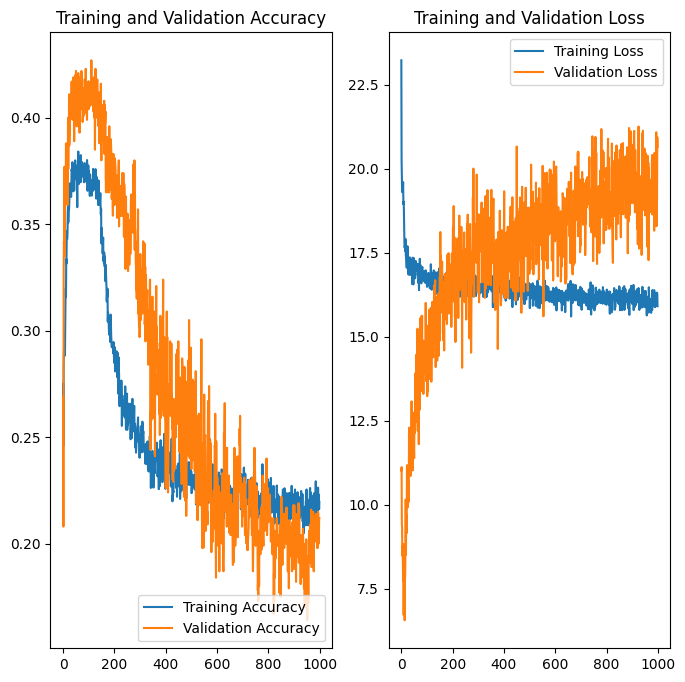

In [31]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(val_epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Guardamos los datos de Accuracy y Loss

In [32]:
df = pd.DataFrame.from_dict(history.history)
df.to_csv('../../../Gráficas finales/History 100,200/historycampvec100funcioncosto.csv', index = False)

# Guardamos el modelo

In [33]:
path_to_save = '../../../Modelos/Modelos 100,200'

In [34]:
model.save(path_to_save + '/campovectorial100funcioncosto.h5')

# Importamos el modelo

In [1]:
def custom_loss(y_true, y_pred):
    campvec = []
    # constantes
    a1 = tf.cast(y_true[:, 0], tf.float64)
    #tf.print(a1)
    a1 = tf.reshape(a1, shape=(-1, 1, 1))

    a2 = tf.cast(y_true[:, 1], tf.float64)
    a2 = tf.reshape(a2, shape=(-1, 1, 1))
    
    b1 = tf.cast(y_true[:, 2], tf.float64)
    b1 = tf.reshape(b1,shape = (-1,1,1))
    
    b2 = tf.cast(y_true[:, 3], tf.float64)
    b2 = tf.reshape(b2,shape = (-1,1,1))

    d1 = tf.cast(y_true[:, 4], tf.float64)
    d1 = tf.reshape(d1, shape=(-1, 1, 1))

    d2 = tf.cast(y_true[:, 5], tf.float64)
    d2 = tf.reshape(d2, shape=(-1, 1, 1))

    n = tf.cast(y_true[:, 6], tf.float64)
    n = tf.reshape(n, shape=(-1, 1, 1))

    def f(t, y):

        # asignar a cada ODE a un elemento de vector
        X = y[0]
        X = tf.cast(X, tf.float64)
        X = tf.reshape(X, shape=(1, 100,100))
        Y = y[1]
        Y = tf.cast(Y, tf.float64)
        Y = tf.reshape(Y, shape=(1, 100,100))
        
        # definimos cada ODE
        dX_dt = tf.divide(a1,(1 + tf.math.pow(Y, n)+1e-5)) - tf.multiply(d1,X) + b1
        dY_dt = tf.divide(a2,(1 + tf.math.pow(X, n)+1e-7)) - tf.multiply(d2,Y) + b2
        return [dX_dt, dY_dt]

    x_range_neg = 0
    x_range_pos = 20
    y_range_neg = 0
    y_range_pos = 20
    y1 = tf.linspace(x_range_neg, x_range_pos, 100)
    y2 = tf.linspace(y_range_neg, y_range_pos, 100)
    Y1, Y2 = tf.meshgrid(y1, y2)
    t = 0
    u, v = tf.zeros(Y1.shape), tf.zeros(Y2.shape)
    u, v = f(t, [Y1, Y2])
    #M = tf.sqrt(tf.square(u) + tf.square(v))
    #u /= M
    #v /= M
# ----------------------------------------------------------------------------
    campvec2 = []
    # constantes
    a12 = tf.cast(y_pred[:, 0], tf.float64)
    a12 = tf.reshape(a12, shape=(-1, 1, 1))

    a22 = tf.cast(y_pred[:, 1], tf.float64)
    a22 = tf.reshape(a22, shape=(-1, 1, 1))
    
    b12 = tf.cast(y_pred[:, 2], tf.float64)
    b12 = tf.reshape(b12,shape = (-1,1,1))
    
    b22 = tf.cast(y_pred[:, 3], tf.float64)
    b22 = tf.reshape(b22,shape = (-1,1,1))

    d12 = tf.cast(y_pred[:, 4], tf.float64)
    d12 = tf.reshape(d12, shape=(-1, 1, 1))

    d22 = tf.cast(y_pred[:, 5], tf.float64)
    d22 = tf.reshape(d22, shape=(-1, 1, 1))

    n2 = tf.cast(y_pred[:, 6], tf.float64)
    n2 = tf.reshape(n2, shape=(-1, 1, 1))
    
    def f2(t2, ye2):

        # asignar a cada ODE a un elemento de vector
        X2 = ye2[0]
        X2 = tf.cast(X2, tf.float64)
        X2 = tf.reshape(X2, shape=(1, 100,100))
        Y2 = ye2[1]
        Y2 = tf.cast(Y2, tf.float64)
        Y2 = tf.reshape(Y2, shape=(1, 100,100))

        # definimos cada ODE
        dX2_dt = tf.divide(a12,(1 + tf.math.pow(Y2, n2)+1e-8)) - tf.multiply(d12,X2) + b12
        dY2_dt = tf.divide(a22,(1 + tf.math.pow(X2, n2)+1e-8)) - tf.multiply(d22,Y2) + b22
        return [dX2_dt, dY2_dt]

    y12 = tf.linspace(x_range_neg, x_range_pos, 100)
    y22 = tf.linspace(y_range_neg, y_range_pos, 100)
    Y12, Y22 = tf.meshgrid(y12, y22)
    u2, v2 = tf.zeros(Y12.shape), tf.zeros(Y22.shape)
    u2, v2 = f2(t, [Y12, Y22])
    #M2 = tf.sqrt(tf.square(u2) + tf.square(v2))
    #u2 /= M2
    #v2 /= M2
    campvecx = tf.abs(tf.subtract(u,u2))
    campvecy = tf.abs(tf.subtract(v,v2))
    campvec_magnitude = tf.add(campvecx,campvecy)
    loss = tf.reduce_mean(campvec_magnitude)
    #tf.print(y_pred)
    return loss

In [2]:
def custom_activation(x):
    return 10 * tf.nn.sigmoid(x)

In [4]:
import keras
import tensorflow as tf
new_model = keras.models.load_model('../../../Modelos/Modelos 100,200/campovectorial100funcioncosto.h5', 
                                    custom_objects={'custom_activation': custom_activation, 'custom_loss': custom_loss})

# Probamos el modelo con datos nuevos

## Creamos nuevos datos

In [9]:
import random
from scipy.integrate import solve_ivp

campvec = []
coef = []
contador = 0
for i in range(0, 1):
    # constantes
    a1 = random.randint(0, 10)
    a2 = random.randint(0, 10)
    b1 = random.randint(0, 10)
    b2 = random.randint(0, 10)
    d1 = random.randint(0, 10)
    d2 = random.randint(0, 10)
    n = random.randint(0, 5)

    coef1 = [a1, a2, b1, b2, d1, d2, n]
    coef.append(coef1)

    def f(t, y):

        # asignar a cada ODE a un elemento de vector
        X = y[0]
        Y = y[1]

        # definimos cada ODE
        # dX_dt=a1/(1+Y**n)-d1*X+b1
        # dY_dt=a2/(1+X**n)-d2*Y+b2
        dX_dt = a1/(1+Y**n)-d1*X+b1
        dY_dt = a2/(1+X**n)-d2*Y+b1

        return [dX_dt, dY_dt]

    x_range_neg = 0
    x_range_pos = 10
    y_range_neg = 0
    y_range_pos =10

    y1 = np.linspace(x_range_neg, x_range_pos, 100)
    y2 = np.linspace(y_range_neg, y_range_pos, 100)

    Y1, Y2 = np.meshgrid(y1, y2)
    
    t1 = 0

    u, v = np.zeros(Y1.shape), np.zeros(Y2.shape)

    NI, NJ = Y1.shape

    u1, v1 = f(t1, [Y1, Y2])
    u, v = f(t1, [Y1, Y2])
    M = (np.hypot(u, v))
    u /= M
    v /= M

    campvecci = np.append([u1], [v1], axis=0)

    campvec = campvecci
    print('--------------------------------------------')
    print(coef1)

    
campvec = np.array(campvec)
coef = np.array(coef)


--------------------------------------------
[6, 9, 3, 0, 4, 1, 0]


In [10]:
campvecnone = campvec[None, :]

## Predecimos con los datos nuevos

In [11]:
new_predictions = new_model.predict(campvecnone)
new_predictions = np.round(new_predictions)
new_predictions = np.clip(new_predictions, 0, None)
print(new_predictions)

1/1 [==============================] - 0s 12ms/step
[[5. 5. 5. 5. 5. 3. 8.]]


##  Encontramos puntos de equilibro datos reales

In [12]:
from scipy.optimize import fsolve
# Sistema de ecuaciones
def system(Y):
    X, Y = Y
    dX_dt = a1/(1+Y**n)-d1*X+b1
    dY_dt = a2/(1+X**n)-d2*Y+b1
    return [dX_dt, dY_dt]

# Adivinanza inicial para X, Y
initial_guess = [0, 0]

# Encontrar los puntos de equilibrio
primer_cuadrante_reales = fsolve(system, initial_guess)
primer_cuadrante_reales = tuple(primer_cuadrante_reales)


print(primer_cuadrante_reales)

(1.5, 7.5)


## Graficamos con los coeficientes reales

Text(0, 0.5, 'Concentración Y')

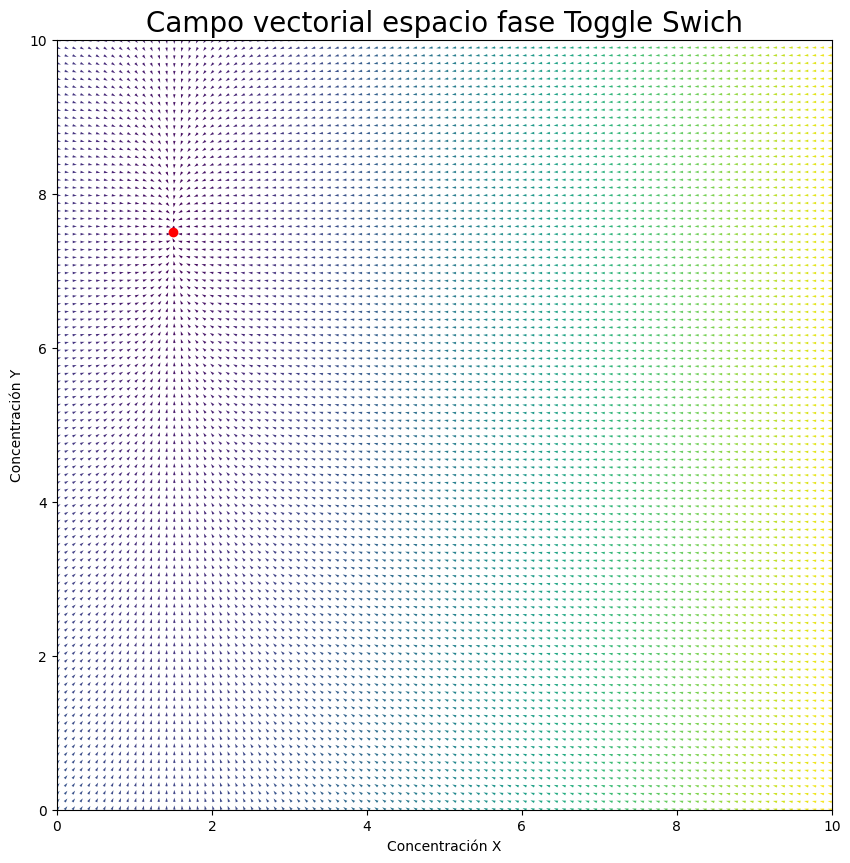

In [13]:
import matplotlib.pyplot as plt

x_values = primer_cuadrante_reales[0]
y_values =primer_cuadrante_reales[1]
y1 = np.linspace(0, 10, 100)
y2 = np.linspace(0, 10, 100)
Y1, Y2 = np.meshgrid(y1, y2)
t1 = 0
u, v = np.zeros(Y1.shape), np.zeros(Y2.shape)
NI, NJ = Y1.shape        
u,v = np.array(campvec)[0,:,:], np.array(campvec)[1,:,:]
M = (np.hypot(u,v))
u /= M
v /= M

plt.figure(figsize=(10,10))
Q = plt.quiver(Y1, Y2, u, v, M, angles='xy')
plt.title('Campo vectorial espacio fase Toggle Swich', fontsize=20)
plt.xlim([0, 10])
plt.ylim([0, 10])
plt.scatter(x_values, y_values, color='red')  # Puedes cambiar el color como prefieras
plt.xlabel('Concentración X')
plt.ylabel('Concentración Y')

## Encontramos puntos de equilibro datos predecidos

In [14]:
a1pred = new_predictions[0,0]
a2pred = new_predictions[0,1]
b1pred = new_predictions[0,2]
b2pred = new_predictions[0,3]
d1pred = new_predictions[0,4]
d2pred = new_predictions[0,5]
npred = new_predictions[0,6]

def systempred(Ypred):
    Xpred, Ypred = Ypred
    dXpred_dt = a1pred/(1+Ypred**npred)-d1pred*Xpred+b1pred
    dYpred_dt = a2pred/(1+Xpred**npred)-d2pred*Ypred+b1pred
    return [dXpred_dt, dYpred_dt]

# Adivinanza inicial para X, Y
initial_guesspred = [0, 0]

# Encontrar los puntos de equilibrio
primer_cuadrante_predecidos = fsolve(systempred, initial_guesspred)
primer_cuadrante_predecidos = tuple(primer_cuadrante_predecidos)


print(primer_cuadrante_predecidos)

(1.0006595520636339, 2.4978022229131303)


## Graficamos con los coeficientes predecidos

Text(0, 0.5, 'Concentración Y')

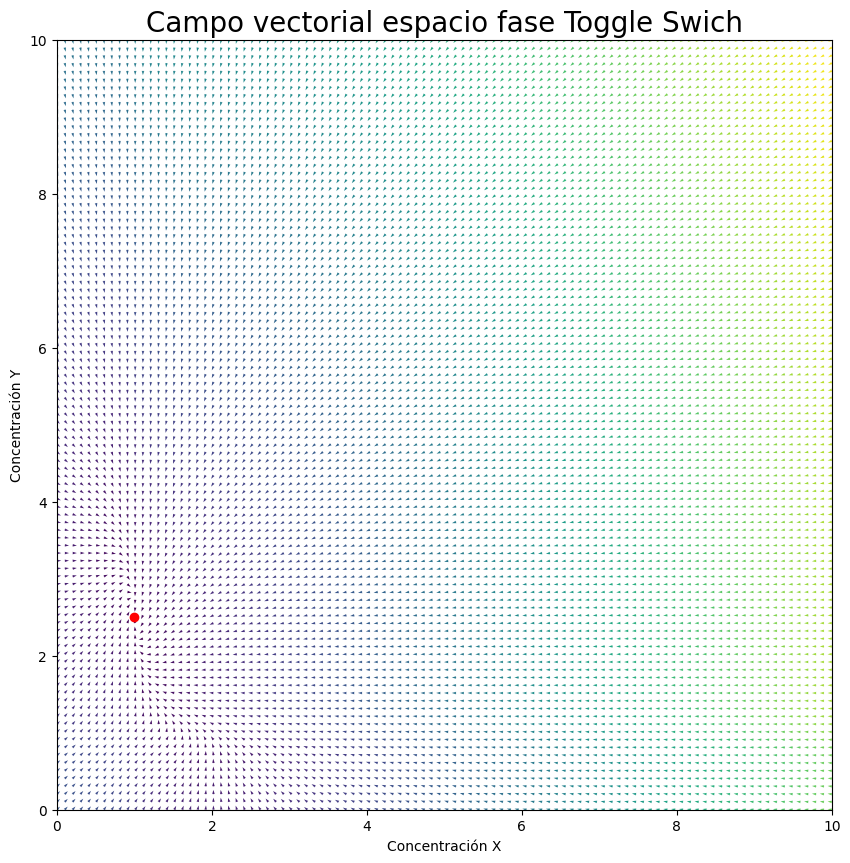

In [15]:
import matplotlib.pyplot as plt

def f(t, y):

    # asignar a cada ODE a un elemento de vector
    X = y[0]
    Y = y[1]

    # definimos cada ODE
    dX_dt = a1pred/(1+Y**npred)-d1pred*X+b1pred
    dY_dt = a2pred/(1+X**npred)-d2pred*Y+b1pred

    return [dX_dt, dY_dt]

x_range_neg = 0
x_range_pos = 10
y_range_neg = 0
y_range_pos = 10

y1pred = np.linspace(x_range_neg, x_range_pos, 100)
y2pred = np.linspace(y_range_neg, y_range_pos, 100)

Y1pred, Y2pred = np.meshgrid(y1pred, y2pred)
    
t1 = 0

upred, vpred = np.zeros(Y1pred.shape), np.zeros(Y2pred.shape)

NI, NJ = Y1.shape

u1pred, v1pred = f(t1, [Y1, Y2])
upred, vpred = f(t1, [Y1, Y2])
Mpred = (np.hypot(upred, vpred))
upred /= Mpred
vpred /= Mpred


x_valuespred = primer_cuadrante_predecidos[0]
y_valuespred =primer_cuadrante_predecidos[1]
plt.figure(figsize=(10, 10))
Q = plt.quiver(Y1, Y2, upred, vpred, Mpred, angles='xy')
plt.title('Campo vectorial espacio fase Toggle Swich', fontsize=20)
plt.xlim([x_range_neg, x_range_pos])
plt.ylim([y_range_neg, y_range_pos])
plt.scatter(x_valuespred, y_valuespred, color='red')  # Puedes cambiar el color como prefieras
plt.xlabel('Concentración X')
plt.ylabel('Concentración Y')

## Graficamos ambos

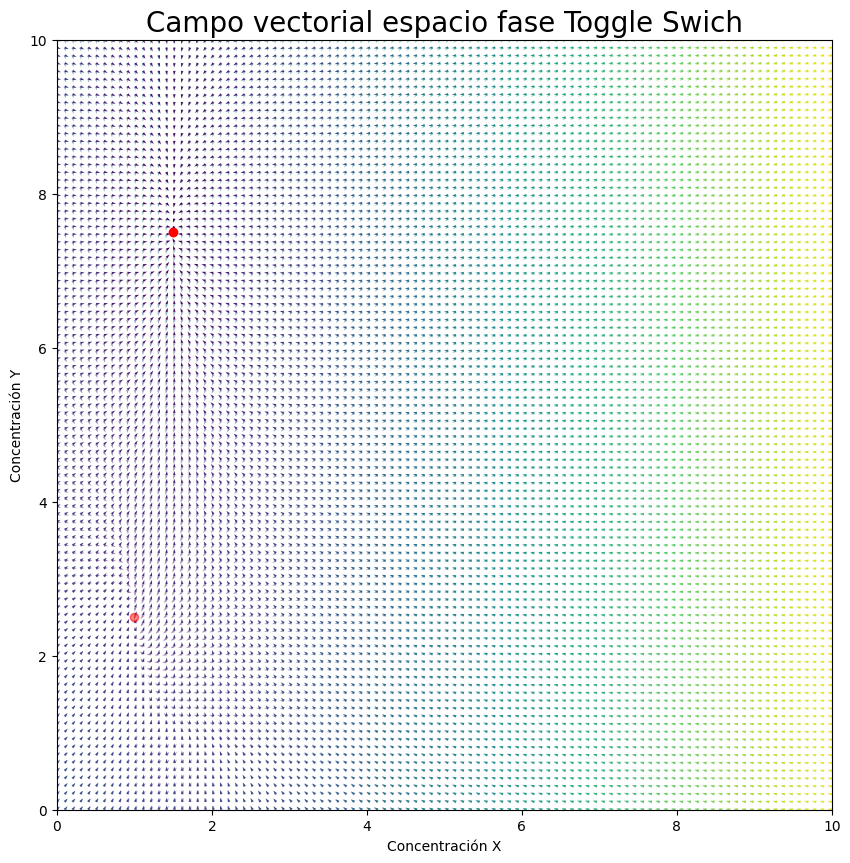

In [16]:
fig, ax = plt.subplots(figsize=(10, 10))

# Primero graficamos la predicción, que debería ser más clara (alpha < 1)
Q = ax.quiver(Y1, Y2, upred, vpred, Mpred, angles='xy', alpha=0.5)

# Luego, graficamos los datos originales, que serán más oscuros (alpha = 1)
Q1 = ax.quiver(Y1, Y2, u, v, M, angles='xy', alpha=1)

ax.scatter(x_valuespred, y_valuespred, color='red', alpha = 0.5)
ax.scatter(x_values, y_values, color='red', alpha = 1)
ax.set_title('Campo vectorial espacio fase Toggle Swich', fontsize=20)
ax.set_xlim([0, 10])
ax.set_ylim([0, 10])
ax.set_xlabel('Concentración X')
ax.set_ylabel('Concentración Y')

plt.show()

## Graficamos las diferencias

59.98175485873322


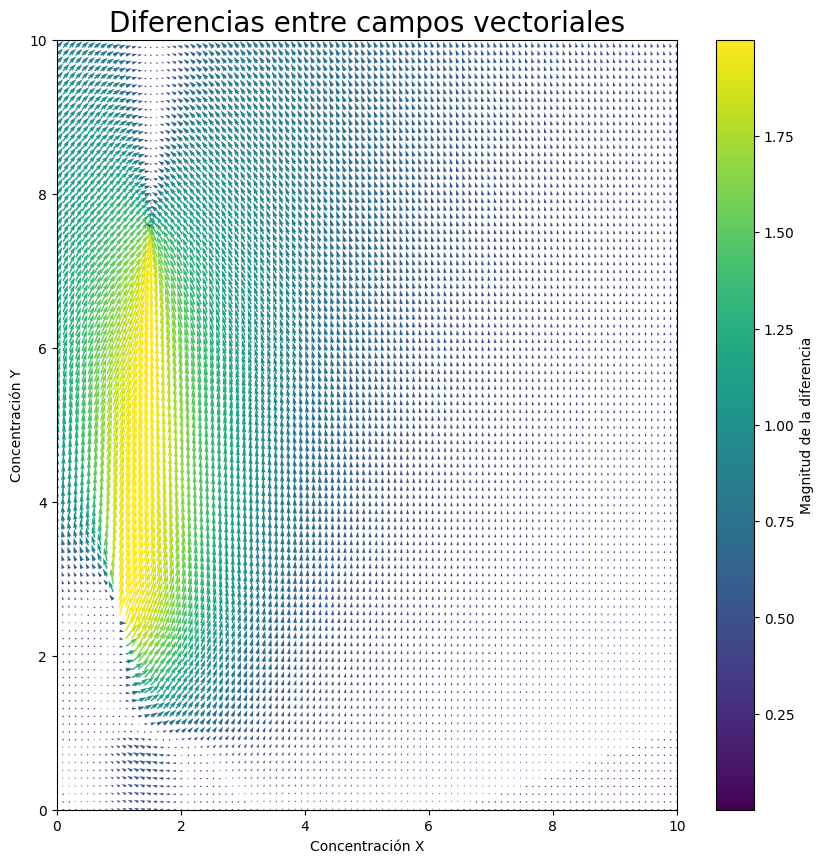

In [17]:
fig, ax = plt.subplots(figsize=(10, 10))

# Calculamos las diferencias
u_diff = u - upred
v_diff = v - vpred

# Aseguramos que ningún vector tenga una magnitud exactamente igual a cero
epsilon = 1e-7
u_diff2 = u_diff + epsilon
v_diff2 = v_diff + epsilon

# Ahora calculamos la magnitud
#M_diff = np.hypot(u_diff2, v_diff2)
M_diff = np.hypot(u_diff, v_diff)

#Calcula la magnitud de los vectores
magnitudes = np.sqrt(u_diff**2 + v_diff**2)

# Calcula el rango de las magnitudes
rango = (np.max(magnitudes) - np.min(magnitudes))*30
print(rango)
# Escala para las flechas. Aumenta este valor si las flechas son demasiado grandes.
scale = 70

# Graficamos las diferencias
#Q = ax.quiver(Y1, Y2, u_diff2, v_diff2, M_diff, angles='xy')
Q = ax.quiver(Y1, Y2, u_diff, v_diff, M_diff, angles='xy', scale = rango)
#Q = ax.quiver(Y1, Y2, u_diff, v_diff, M_diff, angles='xy')


ax.set_title('Diferencias entre campos vectoriales', fontsize=20)
ax.set_xlim([0, 10])
ax.set_ylim([0, 10])
ax.set_xlabel('Concentración X')
ax.set_ylabel('Concentración Y')

# Creamos una leyenda para la magnitud de las flechas
cbar = plt.colorbar(Q, ax=ax)
cbar.set_label('Magnitud de la diferencia')

plt.show()

In [18]:
M_diff.mean()

0.659567846166806